# [Tensorflow-quantum](https://www.tensorflow.org/quantum)
 Guides and tutorials are [here](https://www.tensorflow.org/quantum/overview)

This library depends on and works with [Cirq](https://quantumai.google/cirq).


## Example: MNIST dataset classification using Quantum neural network

Starting with the neccesary imports


In [18]:
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import sympy
import numpy as np
import seaborn as sns
import collections
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

Next we load our dataset:

In [19]:
#Loading dataset from keras.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescaling the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of training examples:", len(x_train))
print("Number of test examples:", len(x_test))


Number of training examples: 60000
Number of test examples: 10000


Showing how the data looks

7


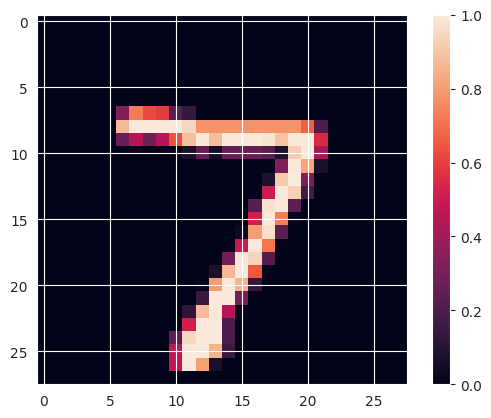

In [20]:
print(y_test[0])

plt.imshow(x_test[0, :, :, 0])
plt.colorbar()
plt.show()

As the current size of the image is too big for efficient simulation, we will next resize our images.

In [21]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

And now, we show the resized version of our data:

7


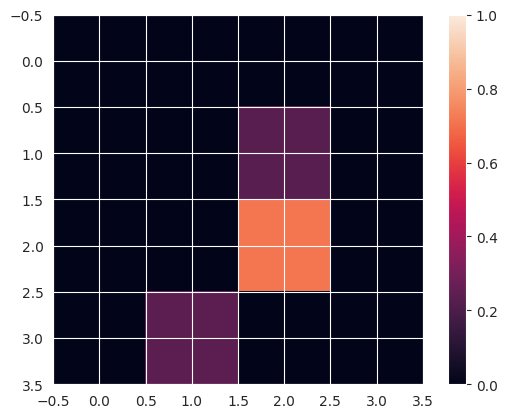

In [22]:
print(y_test[0])

plt.imshow(x_test_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()
plt.show()

## Encoding the data as quantum circuits

Using aproach by [Farhi and Neven](https://arxiv.org/pdf/1802.06002.pdf), where each pixel is represented by one qubit with the state depending on the value.

In [23]:
# Transforming the values to the binary format
THRESHOLD = 0.5
x_train_bin = np.array(x_train_small> THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

Encoding the data to circuits

In [24]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 1)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]


Showing how the circuit looks for first data sample.

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


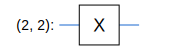

In [25]:
SVGCircuit(x_test_circ[0])


Now we check, if the encoding was done correctly by comparing it with indices of pixels that exceed our treshold.

In [26]:
bin_img = x_test_bin[0,:,:,0]
indices = np.array(np.where(bin_img)).T
indices

array([[2, 2]])

Now we convert our circuits to tensors to use with tensorflow-quantum

In [27]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

## Creating layers

In [28]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout

    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)


Building and displaying an example circuit layer.

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


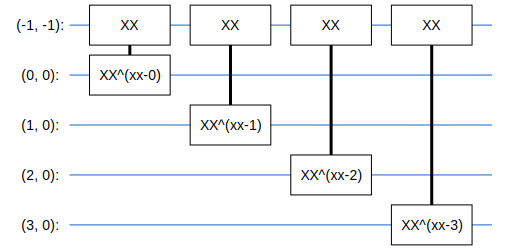

In [29]:
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(4,1),
                                   readout=cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)


Creating two layer model:

In [30]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()

    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))

    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)


In [31]:
model_circuit, model_readout = create_quantum_model()


Wraping our model in Tensorflow - Quantum Keras model

In [43]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])


/home/sillesova/anaconda3/envs/tensor-env/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Converting labels from boolean to [-1,1].

In [44]:
y_train_hinge = 2.0*y_train-1.0
y_test_hinge = 2.0*y_test-1.0


Defining metric:

In [45]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)


Compiling model:

In [46]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])


In [47]:
print(model.summary())


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc_1 (PQC)                 (None, 1)                 32        
                                                                 
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


## Training our model

In [50]:
EPOCHS = 3
BATCH_SIZE = 50

NUM_EXAMPLES = 500

x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]


In [51]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)


Epoch 1/3
10/10 [==============================] - 62s 7s/step - loss: 0.9511 - hinge_accuracy: 0.6860 - val_loss: 0.9331 - val_hinge_accuracy: 0.8126
Epoch 2/3
10/10 [==============================] - 64s 7s/step - loss: 0.9139 - hinge_accuracy: 0.8140 - val_loss: 0.8976 - val_hinge_accuracy: 0.7971
Epoch 3/3
313/313 [==============================] - 47s 152ms/step - loss: 0.9064 - hinge_accuracy: 0.8116


## Classical Model for comparison

In [52]:
def create_fair_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(4,4,1)))
    model.add(tf.keras.layers.Dense(2, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_fair_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 34        
                                                                 
 dense_3 (Dense)             (None, 1)                 3         
                                                                 
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [58]:
model.fit(x_train_bin,
          y_train,
          batch_size=128,
          epochs=3,
          verbose=2,
          validation_data=(x_test_bin, y_test))

fair_nn_results = model.evaluate(x_test_bin, y_test)


Epoch 1/3
469/469 - 2s - loss: -1.6892e+02 - accuracy: 0.1124 - val_loss: -1.6921e+02 - val_accuracy: 0.1135 - 2s/epoch - 4ms/step
Epoch 2/3
469/469 - 1s - loss: -1.7053e+02 - accuracy: 0.1124 - val_loss: -1.7082e+02 - val_accuracy: 0.1135 - 1s/epoch - 3ms/step
Epoch 3/3
469/469 - 1s - loss: -1.7215e+02 - accuracy: 0.1124 - val_loss: -1.7243e+02 - val_accuracy: 0.1135 - 1s/epoch - 3ms/step
313/313 [==============================] - 0s 1ms/step - loss: -172.4257 - accuracy: 0.1135


## Comparison

<Axes: >

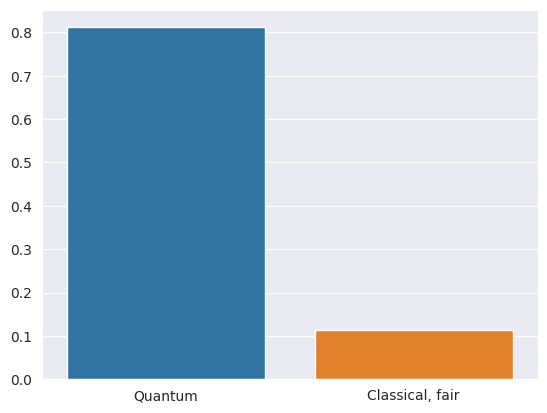

In [59]:
qnn_accuracy = qnn_results[1]
fair_nn_accuracy = fair_nn_results[1]

sns.barplot(x=["Quantum", "Classical, fair"],
            y=[qnn_accuracy, fair_nn_accuracy])

